## 1. Import Library

In [1]:
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import xgboost as xgb
# from optuna.integration import lightgbm as opt_lgb
import optuna
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)

## 2. Load data

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sample_sub = pd.read_csv("../data/sample_submit.csv")
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("../data/genre_labels.csv")

## 3. Preparation

In [3]:
N_CLASSES = 11

In [4]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

### 4. Feature Engineering

### 4-1. 基本的な操作
- lgbm_knn_baselineと同様
    - tempo : tempo(meanで置き換え), tempo_low, tempo_high, tempo_div
    - region : one-hot-encoding, CE_region(count-encoding), LE_region(label-encoding)
    - num_nans
- 新たに追加
    - tempo : tempo_sum, tempo_diff
    - popularity : popularity01, popularity10

In [5]:
# genre_name
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

# tempo
tempo = df["tempo"].str.split("-").apply(pd.Series).astype(float)
tempo.columns = ["tempo_low", "tempo_high"]
df = pd.concat([df, tempo], axis=1)

df["tempo_sum"] = df["tempo_low"] + tempo["tempo_high"]
df["tempo_diff"] = df["tempo_high"] - tempo["tempo_low"]
df["tempo_div"] = df["tempo_low"] / tempo["tempo_high"]

# df["tempo_low"] = df["tempo_low"].replace(0.0, 0.001)
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

# region
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

# num_nans
df["num_nans"] = 0
for col in ["acousticness", "positiveness", 
            "danceability", "energy", "liveness", 
            "speechiness", "instrumentalness"]:
    df["num_nans"] += df[col].isna()
    

# popularity
popularity = df["popularity"].astype(str).str.zfill(2)
popularity = [[i[0], i[1]] for i in popularity]
popularity = pd.DataFrame(popularity, columns=["popularity10", "popularity01"])
popularity = popularity.astype(int)
df = pd.concat([df, popularity], axis=1)
df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown,num_nans,popularity10,popularity01
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,0,0,1,1
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,0,0,6,9
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,0,0,4,3
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,0,0,4,5
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,0,0,1,0,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0,0,0,0,0,0,0,0,3,4
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0,0,0,0,0,0,0,0,5,3
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0,0,0,0,0,0,0,0,4,8
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0,0,0,0,0,0,0,0,4,5


### 4-2. Encoder
- CountEncoder : region
- LabelEncoder : region

In [6]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)
    
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["CE_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "CE_" + col] = np.nan


columns_label_enc = ["region"]
for col in columns_count_enc:
    df["LE_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "LE_" + col] = np.nan

df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_Q,region_R,region_S,region_T,region_unknown,num_nans,popularity10,popularity01,CE_region,LE_region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,1,1,385.0,7.0
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,6,9,1573.0,8.0
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,4,3,1353.0,4.0
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,4,5,171.0,2.0
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,1,0,5,7,696.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0,0,0,0,0,0,3,4,673.0,1.0
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0,0,0,0,0,0,5,3,1573.0,8.0
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0,0,0,0,0,0,4,8,385.0,7.0
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0,0,0,0,0,0,4,5,673.0,1.0


### 4-3. 集約特徴量
- regionの集約特徴量を作成
- min, mean, max, median, std, max-min, q75-q25, zscore

In [7]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)   

# 集約特徴量作成時に使用
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)
    
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 
     'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 
     'instrumentalness',
     'tempo', 'tempo_low', 'tempo_high',
     'popularity10', 'popularity01'], 
    ["min", "mean", "max", "median", "std", max_min, q75_q25, "zscore"]
)
df = pd.concat([df, gfe.fit_transform(df)], axis=1)
df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,agg_zscore_loudness_grpby_region,agg_zscore_energy_grpby_region,agg_zscore_liveness_grpby_region,agg_zscore_speechiness_grpby_region,agg_zscore_instrumentalness_grpby_region,agg_zscore_tempo_grpby_region,agg_zscore_tempo_low_grpby_region,agg_zscore_tempo_high_grpby_region,agg_zscore_popularity10_grpby_region,agg_zscore_popularity01_grpby_region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,1.512742,1.361700,0.538449,2.294931,3.791753,0.511301,0.418672,0.591510,-1.159327,-1.044247
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0.481851,1.326272,-0.499695,-0.500337,-0.587831,1.414210,1.479560,1.342325,1.425982,1.663014
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,-0.488448,-0.808778,-0.288703,1.980912,-0.252552,-1.797012,-1.634219,-1.934995,0.048978,-0.599708
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0.312116,0.993184,0.833359,0.436282,-0.293784,1.817014,1.989646,1.634625,0.290296,0.103498
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0.953197,0.195902,-0.617285,0.206761,0.088274,-0.510415,-0.496445,-0.519646,0.805682,0.951385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,1.146514,0.970917,0.342260,0.222365,-0.121337,0.442081,0.345447,0.528850,-0.282831,-0.117197
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0.621439,0.050088,-0.688451,-0.007002,-0.156765,0.476541,0.374030,0.568536,0.825106,-0.433637
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,-0.152429,0.484505,0.268481,-0.906510,-0.572775,0.511301,0.418672,0.591510,0.609527,1.448442
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,1.383579,0.988935,0.595628,-0.343720,-0.360130,0.442081,0.345447,0.528850,0.353776,0.221316


### 4-4. KNN

In [8]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)
        
        return df_knn

In [9]:
# feature scaling

df["log_tempo"] = np.log(df["tempo"])

for col in ['popularity', 'duration_ms', 'acousticness', 
            'positiveness', 'danceability', 'loudness', 
            'energy', 'liveness', 'speechiness', 'instrumentalness', 
            'log_tempo', 'num_nans']:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [10]:
df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [11]:
# feature weights

knn_features = ['region_A', 'region_B', 'region_C', 'region_D', 'region_E', 
            'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 
            'region_K', 'region_L', 'region_M', 'region_N', 'region_O', 
            'region_P', 'region_Q', 'region_R', 'region_S', 'region_T',
            'region_unknown', 'standardscaled_popularity', 'standardscaled_duration_ms',
            'standardscaled_acousticness', 'standardscaled_positiveness',
            'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy',
            'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness',
            'standardscaled_log_tempo',
            'standardscaled_num_nans']

dict_feature_weights = {}

for col in knn_features[:21]:
    dict_feature_weights[col] = 100.0

for col in ['standardscaled_duration_ms', 'standardscaled_acousticness', 'standardscaled_positiveness',
            'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy',
            'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness']:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

## 5. Training
- optunaを用いてパラメータチューニング
- CrossValidation (n_splits=15)で学習

In [12]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()
knn_n_neighbors = 6

features_numerical = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 
    'tempo', 'tempo_low', 'tempo_high',
    'tempo_sum', 'tempo_diff', 'tempo_div',
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown', 
    'CE_region',
    'num_nans',
    'popularity01', 'popularity10',
    # z-score
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_tempo_grpby_region',
    'agg_zscore_tempo_low_grpby_region',
    'agg_zscore_tempo_high_grpby_region',
    'agg_zscore_popularity10_grpby_region',
    'agg_zscore_popularity01_grpby_region',
    # min
    'agg_min_popularity_grpby_region',
    'agg_min_duration_ms_grpby_region',
    'agg_min_acousticness_grpby_region',
    'agg_min_positiveness_grpby_region',
    'agg_min_danceability_grpby_region',
    'agg_min_loudness_grpby_region',
    'agg_min_energy_grpby_region',
    'agg_min_liveness_grpby_region',
    'agg_min_speechiness_grpby_region',
    'agg_min_instrumentalness_grpby_region',
    'agg_min_tempo_grpby_region',
    'agg_min_tempo_low_grpby_region',
    'agg_min_tempo_high_grpby_region',
    'agg_min_popularity10_grpby_region',
    'agg_min_popularity01_grpby_region',
    # mean
    'agg_mean_popularity_grpby_region',
    'agg_mean_duration_ms_grpby_region',
    'agg_mean_acousticness_grpby_region',
    'agg_mean_positiveness_grpby_region',
    'agg_mean_danceability_grpby_region',
    'agg_mean_loudness_grpby_region',
    'agg_mean_energy_grpby_region',
    'agg_mean_liveness_grpby_region',
    'agg_mean_speechiness_grpby_region',
    'agg_mean_instrumentalness_grpby_region',
    'agg_mean_tempo_grpby_region',
    'agg_mean_tempo_low_grpby_region',
    'agg_mean_tempo_high_grpby_region',
    'agg_mean_popularity10_grpby_region',
    'agg_mean_popularity01_grpby_region',
    # max
    'agg_max_popularity_grpby_region',
    'agg_max_duration_ms_grpby_region',
    'agg_max_acousticness_grpby_region',
    'agg_max_positiveness_grpby_region',
    'agg_max_danceability_grpby_region',
    'agg_max_loudness_grpby_region',
    'agg_max_energy_grpby_region',
    'agg_max_liveness_grpby_region',
    'agg_max_speechiness_grpby_region',
    'agg_max_instrumentalness_grpby_region',
    'agg_max_tempo_grpby_region',
    'agg_max_tempo_low_grpby_region',
    'agg_max_tempo_high_grpby_region',
    'agg_max_popularity10_grpby_region',
    'agg_max_popularity01_grpby_region',
    # median
    'agg_median_popularity_grpby_region',
    'agg_median_duration_ms_grpby_region',
    'agg_median_acousticness_grpby_region',
    'agg_median_positiveness_grpby_region',
    'agg_median_danceability_grpby_region',
    'agg_median_loudness_grpby_region',
    'agg_median_energy_grpby_region',
    'agg_median_liveness_grpby_region',
    'agg_median_speechiness_grpby_region',
    'agg_median_instrumentalness_grpby_region',
    'agg_median_tempo_grpby_region',
    'agg_median_tempo_low_grpby_region',
    'agg_median_tempo_high_grpby_region',
    'agg_median_popularity10_grpby_region',
    'agg_median_popularity01_grpby_region',
    # std
    'agg_std_popularity_grpby_region',
    'agg_std_duration_ms_grpby_region',
    'agg_std_acousticness_grpby_region',
    'agg_std_positiveness_grpby_region',
    'agg_std_danceability_grpby_region',
    'agg_std_loudness_grpby_region',
    'agg_std_energy_grpby_region',
    'agg_std_liveness_grpby_region',
    'agg_std_speechiness_grpby_region',
    'agg_std_instrumentalness_grpby_region',
    'agg_std_tempo_grpby_region',
    'agg_std_popularity10_grpby_region',
    'agg_std_popularity01_grpby_region',
    # max_min
    'agg_max_min_popularity_grpby_region',
    'agg_max_min_duration_ms_grpby_region',
    'agg_max_min_acousticness_grpby_region',
    'agg_max_min_positiveness_grpby_region',
    'agg_max_min_danceability_grpby_region',
    'agg_max_min_loudness_grpby_region',
    'agg_max_min_energy_grpby_region',
    'agg_max_min_liveness_grpby_region',
    'agg_max_min_speechiness_grpby_region',
    'agg_max_min_instrumentalness_grpby_region',
    'agg_max_min_tempo_grpby_region',
    'agg_max_min_tempo_low_grpby_region',
    'agg_max_min_tempo_high_grpby_region',
    'agg_max_min_popularity10_grpby_region',
    'agg_max_min_popularity01_grpby_region',
    # q75_q25
    'agg_q75_q25_popularity_grpby_region',
    'agg_q75_q25_duration_ms_grpby_region',
    'agg_q75_q25_acousticness_grpby_region',
    'agg_q75_q25_positiveness_grpby_region',
    'agg_q75_q25_danceability_grpby_region',
    'agg_q75_q25_loudness_grpby_region',
    'agg_q75_q25_energy_grpby_region',
    'agg_q75_q25_liveness_grpby_region',
    'agg_q75_q25_speechiness_grpby_region',
    'agg_q75_q25_instrumentalness_grpby_region',
    'agg_q75_q25_tempo_grpby_region',
    'agg_q75_q25_tempo_low_grpby_region',
    'agg_q75_q25_tempo_high_grpby_region',
    'agg_q75_q25_popularity10_grpby_region',
    'agg_q75_q25_popularity01_grpby_region',
    # knn
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]
features_categorical = ["LE_region"]
features = features_numerical + features_categorical
print(len(features))

203


In [19]:
def objective(trial):
    
    # make knn features
    X = df_train[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target)
    _df_train = pd.concat([df_train, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    
    # train valid split    
    folds = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
    indexes_trn, indexes_val = 0, 0
    for trn_idx, val_idx in folds.split(_df_train.values, target.values):
        indexes_trn = trn_idx
        indexes_val = val_idx
    
    df_trn = _df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = _df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)
    
    # make datasets
    xgb_train = xgb.DMatrix(df_trn.loc[:, features], label=target_trn)
    xgb_valid = xgb.DMatrix(df_val.loc[:, features], label=target_val)
    
    # parameters
    base_params = {
        "objective": "multi:softprob",
        "num_class": N_CLASSES,
        "eval_metric": "mlogloss",
        "learning_rate": 0.01,
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "verbosity": 0,
        "seed": 42,
    }
    
    num_round = 999999999
    model = xgb.train(
        base_params,
        xgb_train, 
        num_round, 
        evals=[(xgb_train, "train"), (xgb_valid, "valid")], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
    )
    
    prediction = model.predict(xgb_valid, ntree_limit=model.best_ntree_limit)
    score = f1_score(target_val, prediction.argmax(1), average="macro")
    return score

In [21]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
    direction="maximize")
study.optimize(objective, n_trials=10)

[I 2021-04-30 23:08:17,682] A new study created in memory with name: no-name-9ba077d9-3365-4d69-b8ec-9f20e2adcc4c


[0]	train-mlogloss:2.36942	valid-mlogloss:2.37005
[300]	train-mlogloss:0.89721	valid-mlogloss:0.95733
[600]	train-mlogloss:0.78369	valid-mlogloss:0.87342
[900]	train-mlogloss:0.73703	valid-mlogloss:0.85746
[1200]	train-mlogloss:0.70451	valid-mlogloss:0.85257
[1500]	train-mlogloss:0.67862	valid-mlogloss:0.85111
[1800]	train-mlogloss:0.65706	valid-mlogloss:0.85147
[1837]	train-mlogloss:0.65463	valid-mlogloss:0.85160


[I 2021-04-30 23:09:57,319] Trial 0 finished with value: 0.6304550449225441 and parameters: {'lambda': 0.14245858695496355, 'alpha': 0.05531131047547221, 'max_depth': 1, 'eta': 0.018995139177238992, 'gamma': 0.14276081212028355}. Best is trial 0 with value: 0.6304550449225441.


[0]	train-mlogloss:2.36655	valid-mlogloss:2.36748
[300]	train-mlogloss:0.79393	valid-mlogloss:0.91273
[600]	train-mlogloss:0.63634	valid-mlogloss:0.84274
[900]	train-mlogloss:0.55995	valid-mlogloss:0.83953
[1142]	train-mlogloss:0.51268	valid-mlogloss:0.84668


[I 2021-04-30 23:10:49,546] Trial 1 finished with value: 0.6400906688710535 and parameters: {'lambda': 5.939870696582341e-08, 'alpha': 2.525990872954684e-08, 'max_depth': 2, 'eta': 4.026094885606524e-07, 'gamma': 0.0044603052797440364}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.36294	valid-mlogloss:2.36620
[300]	train-mlogloss:0.52191	valid-mlogloss:0.89855
[600]	train-mlogloss:0.31352	valid-mlogloss:0.84968
[844]	train-mlogloss:0.24279	valid-mlogloss:0.86019


[I 2021-04-30 23:12:03,206] Trial 2 finished with value: 0.6274127707340826 and parameters: {'lambda': 1.765499512476602e-06, 'alpha': 0.0021644771583404303, 'max_depth': 4, 'eta': 3.804998401957208e-08, 'gamma': 2.898705814125541e-08}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.35778	valid-mlogloss:2.36533
[300]	train-mlogloss:0.22907	valid-mlogloss:0.92343
[600]	train-mlogloss:0.07755	valid-mlogloss:0.90687
[728]	train-mlogloss:0.05709	valid-mlogloss:0.92589


[I 2021-04-30 23:13:43,851] Trial 3 finished with value: 0.6396513945123794 and parameters: {'lambda': 1.0316462746752647e-08, 'alpha': 4.6714666761777726e-07, 'max_depth': 7, 'eta': 9.369574118711403e-06, 'gamma': 1.5415555902646863e-05}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.36473	valid-mlogloss:2.36674
[300]	train-mlogloss:0.66241	valid-mlogloss:0.90165
[600]	train-mlogloss:0.46472	valid-mlogloss:0.84502
[900]	train-mlogloss:0.37882	valid-mlogloss:0.85152
[931]	train-mlogloss:0.37190	valid-mlogloss:0.85294


[I 2021-04-30 23:14:45,374] Trial 4 finished with value: 0.6307466798131602 and parameters: {'lambda': 0.00021321013943517817, 'alpha': 6.213389725372447e-08, 'max_depth': 3, 'eta': 0.0010049997109512487, 'gamma': 0.0004433316248138135}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.35926	valid-mlogloss:2.36551
[300]	train-mlogloss:0.29436	valid-mlogloss:0.91418
[600]	train-mlogloss:0.11907	valid-mlogloss:0.88652
[788]	train-mlogloss:0.08272	valid-mlogloss:0.90422


[I 2021-04-30 23:16:16,797] Trial 5 finished with value: 0.6354398126902322 and parameters: {'lambda': 8.475704075654538e-07, 'alpha': 0.03445397452660148, 'max_depth': 6, 'eta': 9.693953242436063e-06, 'gamma': 0.06075406236301545}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.35837	valid-mlogloss:2.36646
[300]	train-mlogloss:0.19072	valid-mlogloss:0.93560
[600]	train-mlogloss:0.05023	valid-mlogloss:0.92643
[736]	train-mlogloss:0.03516	valid-mlogloss:0.94693


[I 2021-04-30 23:18:02,106] Trial 6 finished with value: 0.6300806226023637 and parameters: {'lambda': 0.20767908572559396, 'alpha': 0.00010997799150387428, 'max_depth': 9, 'eta': 1.2019059960687092e-05, 'gamma': 3.2582378566626437e-07}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.35926	valid-mlogloss:2.36551
[300]	train-mlogloss:0.29279	valid-mlogloss:0.91306
[600]	train-mlogloss:0.11754	valid-mlogloss:0.88367
[788]	train-mlogloss:0.08144	valid-mlogloss:0.90202


[I 2021-04-30 23:19:31,456] Trial 7 finished with value: 0.6335493161677266 and parameters: {'lambda': 0.0008289015829761813, 'alpha': 0.03220161515667895, 'max_depth': 6, 'eta': 0.0016136486986526026, 'gamma': 0.004223924946629797}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.35838	valid-mlogloss:2.36585
[300]	train-mlogloss:0.25235	valid-mlogloss:0.92242
[600]	train-mlogloss:0.08422	valid-mlogloss:0.89701
[753]	train-mlogloss:0.05660	valid-mlogloss:0.91455


[I 2021-04-30 23:21:08,244] Trial 8 finished with value: 0.6365109948800766 and parameters: {'lambda': 0.00011089547853310449, 'alpha': 0.2093639009023804, 'max_depth': 7, 'eta': 4.616767539636701e-08, 'gamma': 1.047195553151149e-08}. Best is trial 1 with value: 0.6400906688710535.


[0]	train-mlogloss:2.36479	valid-mlogloss:2.36771
[300]	train-mlogloss:0.55250	valid-mlogloss:0.90012
[600]	train-mlogloss:0.33671	valid-mlogloss:0.84591
[886]	train-mlogloss:0.24993	valid-mlogloss:0.85401


[I 2021-04-30 23:22:22,126] Trial 9 finished with value: 0.643134107449546 and parameters: {'lambda': 0.5538148135420834, 'alpha': 0.18205118298823894, 'max_depth': 4, 'eta': 0.00015769501335977814, 'gamma': 0.003577075167215691}. Best is trial 9 with value: 0.643134107449546.


In [22]:
# 最も良かったスコアとパラメータを書き出す
print(study.best_trial)

FrozenTrial(number=9, values=[0.643134107449546], datetime_start=datetime.datetime(2021, 4, 30, 23, 21, 8, 245422), datetime_complete=datetime.datetime(2021, 4, 30, 23, 22, 22, 125861), params={'lambda': 0.5538148135420834, 'alpha': 0.18205118298823894, 'max_depth': 4, 'eta': 0.00015769501335977814, 'gamma': 0.003577075167215691}, distributions={'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=9, state=TrialState.COMPLETE, value=None)


In [27]:
# Optunaにより得られた最適なパラメータ
learning_rate = 0.01
tuning_params = {
    "objective": "multi:softprob",
    "num_class": N_CLASSES,
    "eval_metric": "mlogloss",
    "learning_rate": learning_rate,
    'lambda': 0.5538148135420834, 
    'alpha': 0.18205118298823894, 
    'max_depth': 4, 
    'eta': 0.00015769501335977814, 
    'gamma': 0.003577075167215691,
    "verbosity": 0,
    "seed": 42,
}

In [28]:
def get_xgb_imp(xgb, feat_names, fold_):
    imp_vals = xgb.get_fscore()
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    feats_imp["fold"] = fold_
    return feats_imp

In [29]:
for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    xgb_train = xgb.DMatrix(df_trn.loc[:, features], label=target_trn)
    xgb_valid = xgb.DMatrix(df_val.loc[:, features], label=target_val)

    tuning_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = xgb.train(
        tuning_params,
        xgb_train, 
        num_round, 
        evals=[(xgb_train, "train"), (xgb_valid, "valid")], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
    )

    # cv
#     prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(xgb_valid, ntree_limit=model.best_ntree_limit)

    # feature importance
#     df_fold_importance = pd.DataFrame()
#     df_fold_importance["feature"] = features
#     df_fold_importance["importance"] = model.booster().get_fscore().items()
#     df_fold_importance["fold"] = fold_
    df_fold_importance = get_xgb_imp(model, features, fold_)
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    # prediction for test data
    predictions += model.predict(xgb.DMatrix(df_test.loc[:, features]), 
                                 ntree_limit=model.best_ntree_limit) / N_SPLITS
    print()

------------------------------ fold 0 ------------------------------
[0]	train-mlogloss:2.36421	valid-mlogloss:2.36821
[300]	train-mlogloss:0.62500	valid-mlogloss:0.92932
[600]	train-mlogloss:0.43748	valid-mlogloss:0.84916
[900]	train-mlogloss:0.34833	valid-mlogloss:0.83033
[1162]	train-mlogloss:0.29545	valid-mlogloss:0.83615

------------------------------ fold 1 ------------------------------
[0]	train-mlogloss:2.36258	valid-mlogloss:2.36510
[300]	train-mlogloss:0.60993	valid-mlogloss:0.85257
[600]	train-mlogloss:0.41959	valid-mlogloss:0.79087
[900]	train-mlogloss:0.33100	valid-mlogloss:0.79051
[1014]	train-mlogloss:0.30571	valid-mlogloss:0.79352

------------------------------ fold 2 ------------------------------
[0]	train-mlogloss:2.36328	valid-mlogloss:2.36467
[300]	train-mlogloss:0.61378	valid-mlogloss:0.86978
[600]	train-mlogloss:0.42616	valid-mlogloss:0.82498
[900]	train-mlogloss:0.33467	valid-mlogloss:0.82528
[978]	train-mlogloss:0.31656	valid-mlogloss:0.82730

--------------

## 6. Test & Visualization

CV score
  f1:  0.64975

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.59      0.43      0.50       205
           2       0.68      0.55      0.61       191
           3       0.80      0.76      0.78       362
           4       0.68      0.56      0.61        45
           5       0.66      0.52      0.58       126
           6       0.58      0.28      0.38        50
           7       0.63      0.61      0.62       334
           8       0.72      0.79      0.75      1305
           9       0.82      0.83      0.82        59
          10       0.78      0.82      0.80      1337

    accuracy                           0.73      4046
   macro avg       0.71      0.61      0.65      4046
weighted avg       0.73      0.73      0.73      4046



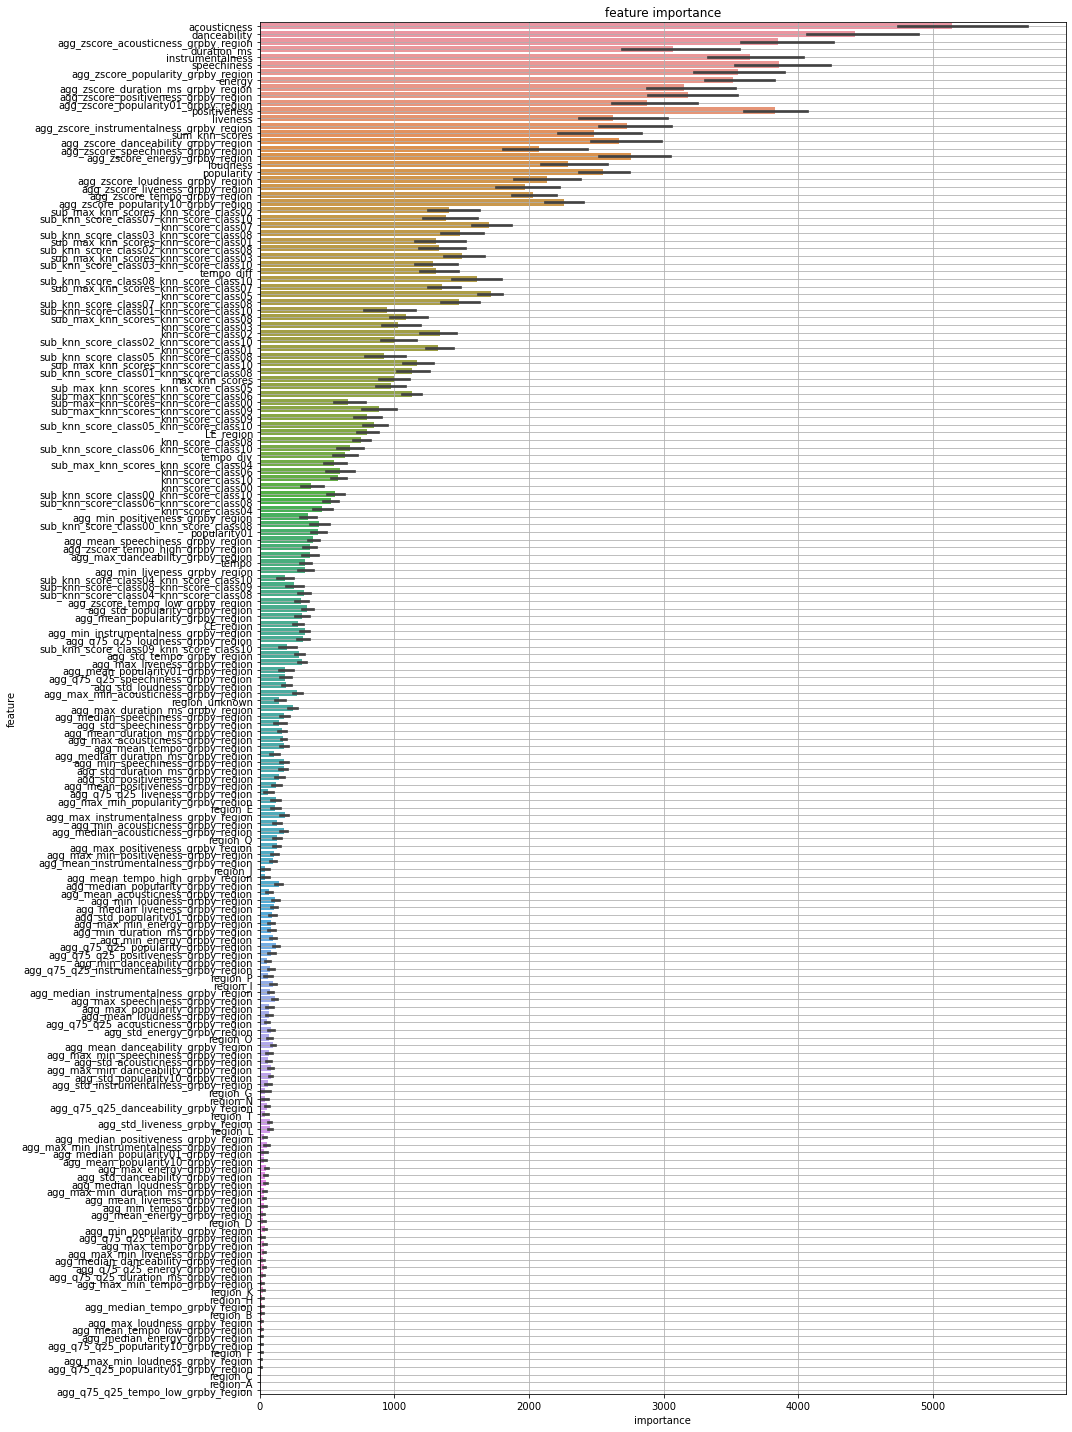

In [30]:
# df_test["prediction"] = predictions.argmax(1)
y_test = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(15, 20))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

In [31]:
# # feature importanceが0の特徴量
# df_train.columns[np.where(model.feature_importance_==0)]

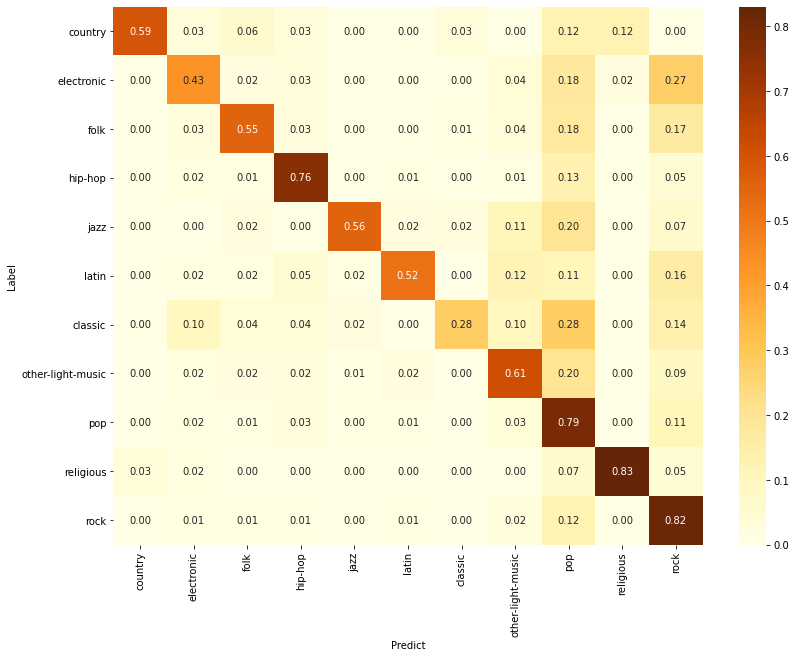

In [32]:
def visualize_confusion_matrix(y_true, pred_label, height=.6, labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true, y_pred=pred_label, normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

    
oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
plt.show(fig)

## 7. Save Result

In [33]:
# Save csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)
submit.columns = ["index", "genre"]

In [34]:
submit

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [35]:
# submit.to_csv("../logs/xgb_knn_v2.csv", header=None, index=None)